In [1]:
from skimage import io, color
from skimage.morphology import binary_closing, binary_opening
from skimage.morphology import disk
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure
from skimage.color import label2rgb
import pydicom as dicom
from scipy.stats import norm
from scipy.spatial import distance

def show_comparison(original, modified, modified_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap="gray", vmin=-200, vmax=500)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(modified)
    ax2.set_title(modified_name)
    ax2.axis('off')
    io.show()

In [2]:
import filters.filters as f
import image_load_and_converttion.load as l
import Analyse as a

(512, 512)
int16
1114


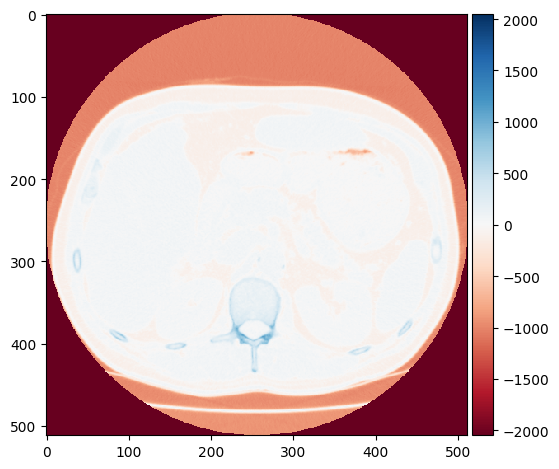

In [3]:
d_img=l.load_dicom("../data/data2/Training.dcm")

mask of p is 


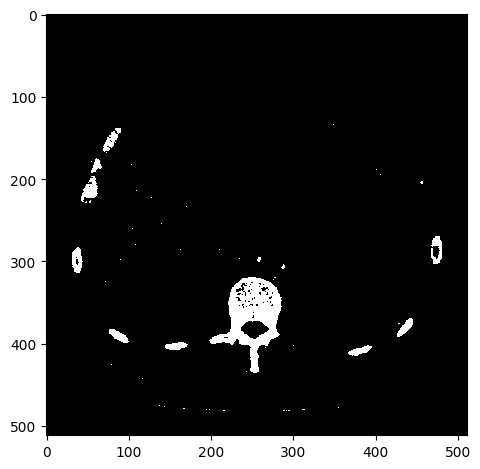

mask of p is 


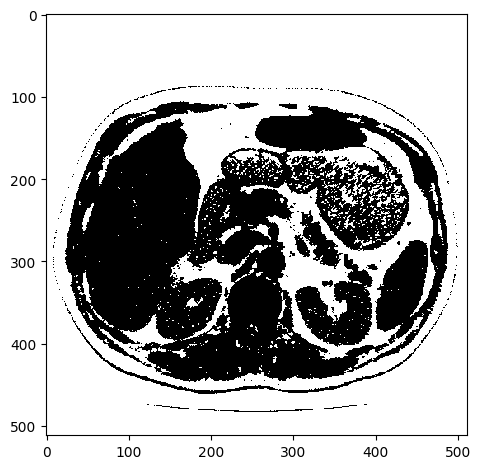

In [4]:
scaled_img=f.grayscale_mask(d_img,0,100)


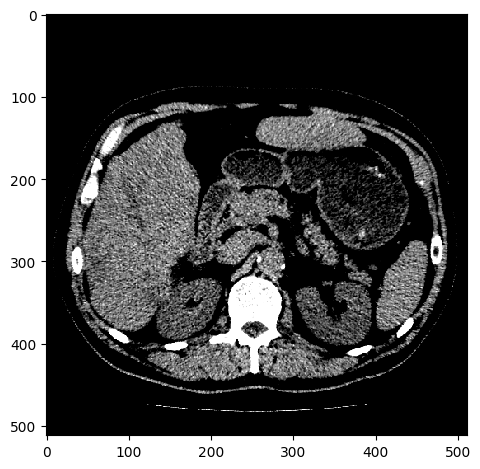

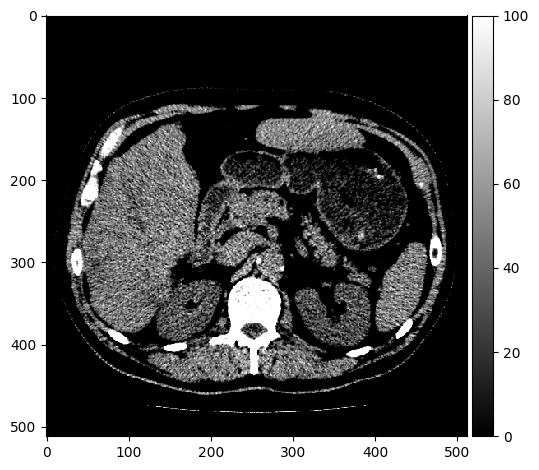

In [5]:
io.imshow(scaled_img)
io.show()
io.imshow(d_img, vmin=0, vmax=100, cmap='gray')
io.show()

In [6]:
dir1="../data/data2/BoneROI.png"
im_b= io.imread(dir1)

dir1="../data/data2/FatROI.png"
im_f = io.imread(dir1)

dir1="../data/data2/KidneyROI.png"
im_k = io.imread(dir1)

dir1="../data/data2/LiverROI.png"
im_l = io.imread(dir1)

dir1="../data/data2/SpleenROI.png"
im_s = io.imread(dir1)


In [7]:
_,r_b=f.roi_values(im_b,d_img)
_,r_f=f.roi_values(im_f,d_img)
_,r_k=f.roi_values(im_k,d_img)
_,r_l=f.roi_values(im_l,d_img)
_,r_s=f.roi_values(im_s,d_img)


In [8]:
mu_b,std_b=np.mean(r_b),np.std(r_b)

mu_f,std_f=np.mean(r_f),np.std(r_f)

mu_k,std_k=np.mean(r_k),np.std(r_k)

mu_l,std_l=np.mean(r_l),np.std(r_l)

mu_s,std_s=np.mean(r_s),np.std(r_s)

soft=np.concatenate((r_s,r_k,r_l))
mu_soft,std_soft=np.mean(soft),np.std(soft)

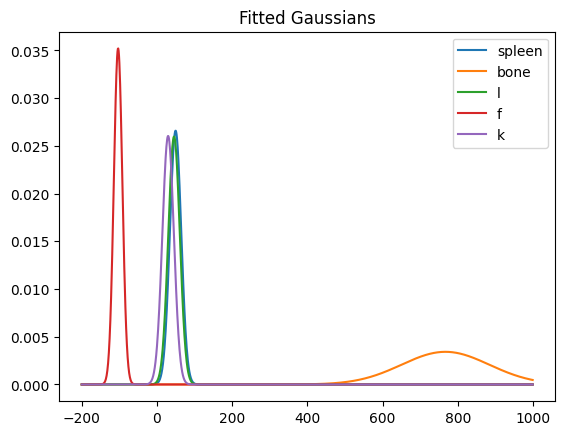

In [9]:
min_hu = -200
max_hu = 1000

hu_range = np.arange(min_hu, max_hu, 1.0)
pdf_spleen = norm.pdf(hu_range, mu_s, std_s)
pdf_bone = norm.pdf(hu_range, mu_b, std_b)
pdf_l = norm.pdf(hu_range, mu_l, std_l)
pdf_f = norm.pdf(hu_range, mu_f, std_f)
pdf_k = norm.pdf(hu_range, mu_k, std_k)

plt.plot(hu_range, pdf_spleen, label="spleen")
plt.plot(hu_range, pdf_bone,  label="bone")

plt.plot(hu_range, pdf_l,  label="l")
plt.plot(hu_range, pdf_f,  label="f")
plt.plot(hu_range, pdf_k, label="k")

plt.title("Fitted Gaussians")
plt.legend()
plt.show()

## Minimum distance pixel classification

In the minimum distance classifier the pixel value class ranges are defined using the average values of the training values. If you have two classes, the threshold between them is defined as the mid-point between the two class value averages.


In the following, we will define four classes: background, fat, soft tissue and bone, where soft-tissue is a combination of the values of the spleen, liver and kidneys. We manually set the threshold for background to -200. So all pixels below -200 are set to background.

In [10]:
soft=np.concatenate((r_s,r_k,r_l))

t_background = -200
t_fat_soft=a.trhold(soft,r_f)
t_soft_bone=a.trhold(soft,r_b)


fat_img = (d_img > t_background) & (d_img <= t_fat_soft)
soft_img = (d_img > t_fat_soft) & (d_img <= t_soft_bone)
bone_img = (d_img > t_soft_bone) 

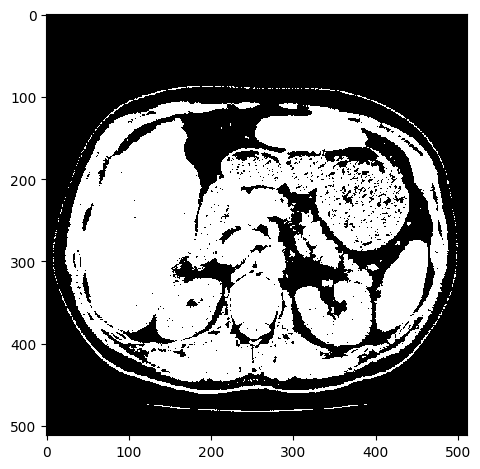

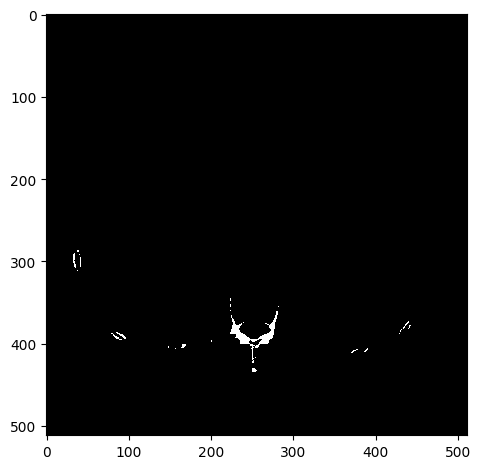

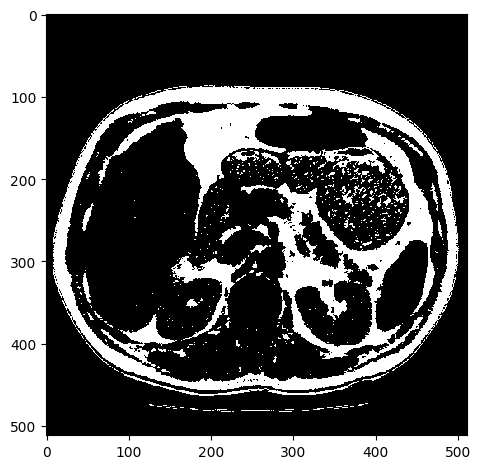

In [11]:
io.imshow(soft_img)
io.show()
io.imshow(bone_img)
io.show()
io.imshow(fat_img)
io.show()


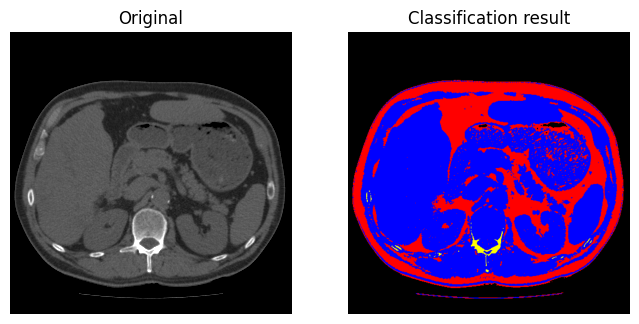

In [12]:
label_img = fat_img + 2 * soft_img + 3 * bone_img
image_label_overlay = label2rgb(label_img)
show_comparison(d_img, image_label_overlay, 'Classification result')



## Parametric pixel classification

In the parametric classifier, the standard deviation of the training pixel values is also used when determinin the class ranges. In the following, we are also trying to classify background, fat, soft tissue and bone.

We start by finding the class ranges by manually inspecting the fitted Gaussians from each class.

As in the last exercise, we can still se the background-fat threshold to be -200.

In [13]:
mu_b,std_b=np.mean(r_b),np.std(r_b)

mu_f,std_f=np.mean(r_f),np.std(r_f)

soft=np.concatenate((r_s,r_k,r_l))
mu_soft,std_soft=np.mean(soft),np.std(soft)

min_hu = -200
max_hu = 1000

#creat nr distabustien
hu_range = np.arange(min_hu, max_hu, 1.0)
pdf_bone = norm.pdf(hu_range, mu_b, std_b)
pdf_f = norm.pdf(hu_range, mu_f, std_f)
pdf_soft=norm.pdf(hu_range, mu_soft, std_soft)

In [14]:


t_background = -200
t_fat_soft=a.pdf_crose(pdf_f,pdf_soft)[0][0]+min_hu
t_soft_bone=a.pdf_crose(pdf_soft,pdf_bone)[0][0]+min_hu


fat_img = (d_img > t_background) & (d_img <= t_fat_soft)
soft_img = (d_img > t_fat_soft) & (d_img <= t_soft_bone)
bone_img = (d_img > t_soft_bone) 


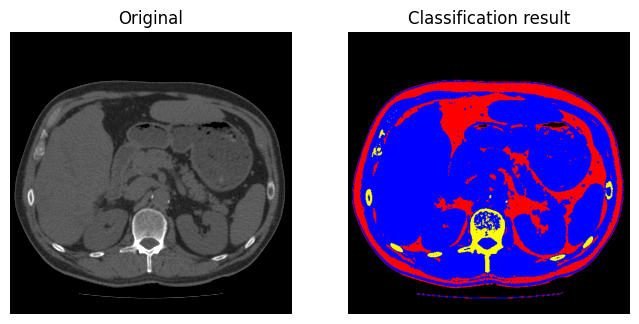

In [15]:
label_img = fat_img + 2 * soft_img + 3 * bone_img
image_label_overlay = label2rgb(label_img)
show_comparison(d_img, image_label_overlay, 'Classification result')

## Object segmentation - The spleen finder
>

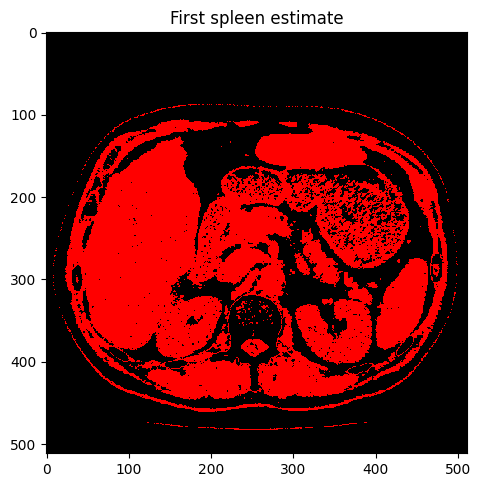

In [16]:
spleen_estimate = (d_img > 0) & (d_img < 100)
spleen_label_colour = color.label2rgb(spleen_estimate)
io.imshow(spleen_label_colour)
plt.title("First spleen estimate")
io.show()

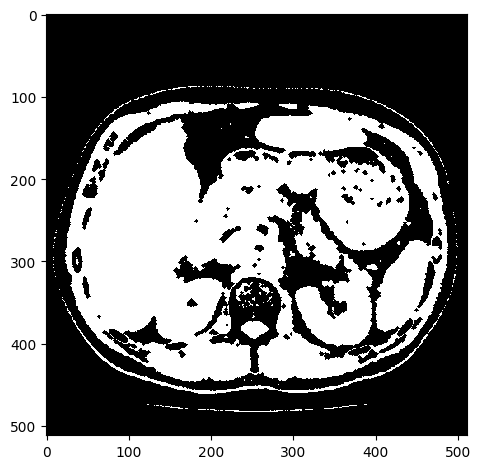

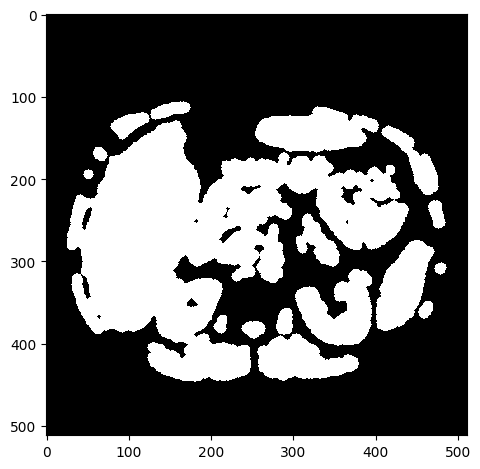

In [17]:
footprint = disk(2)
closed = binary_closing(spleen_estimate, footprint)
io.imshow(closed)
io.show()
footprint = disk(6)
opened = binary_opening(closed, footprint)

io.imshow(opened)

Number of labels: 17


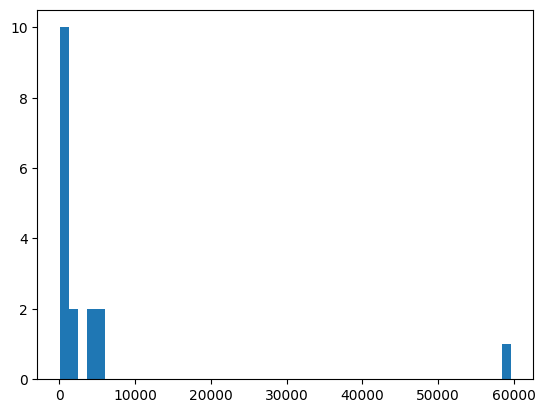

In [18]:
feacheres=a.blobanalyse(opened)


In [19]:
probs=measure.regionprops(feacheres)
labels=[prob.label for prob in probs]
print(labels)
areas=  [prob.area for prob in probs] 
print(areas)
paremeter=  [prob.perimeter for prob in probs] 
print(paremeter[9])


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
[685.0, 5684.0, 889.0, 59567.0, 2012.0, 220.0, 113.0, 504.0, 1720.0, 4684.0, 163.0, 5311.0, 273.0, 551.0, 260.0, 450.0, 4391.0]
309.3624817342638


In [20]:
areas[9]

4684.0

122.32590180780451
1
1
1
404.0904037956216
2
128.36753236814712
3
3
3
3100.064463543177
4
4
4
257.8061325481597
5
5
5
54.526911934581186
6
6
6
38.62741699796952
7
7
7
95.25483399593904
8
8
8
232.24978336205572
9
9
9
309.3624817342638
10
46.8700576850888
11
11
11
434.0731598529186
12
62.18376618407356
13
13
13
92.42640687119285
14
14
14
65.01219330881976
15
15
15
80.66904755831214
16
16
16
340.33304448274095
17


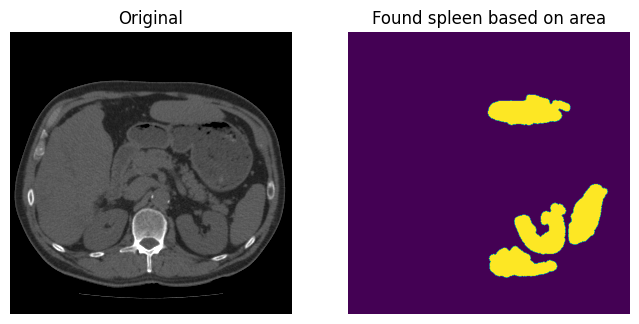

In [30]:
max_p=310
min_p=290
max_a=6000
min_a=4000
# Create a copy of the label_img
label_img_filter = feacheres.copy()
region_props = measure.regionprops(feacheres)
for region in region_props:
    # Find the areas that do not fit our criteria

    #this is the place we wont to change if not clacyfi after areqa but shape
    print(region.perimeter)
    print(region.label)
    if region.area > max_a or region.area < min_a or region.perimeter > max_p or region.perimeter < min_p:


            

            # set the pixels in the invalid areas to background
            for cords in region.coords:
                label_img_filter[cords[0], cords[1]] = 0

# Create binary image from the filtered label image
i_area = label_img_filter > 0
show_comparison(d_img, i_area, 'Found spleen based on area')